In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
import warnings

In [3]:
socio = pd.read_feather('BF_Dados_Socio_Economicos.feather')
socio = socio.drop_duplicates('identificação')
cont = pd.read_feather('BF_Dados_Contratos.feather')
cont = cont.loc[cont['CONTRATO'] > 40000]
df = cont.join(socio.set_index('identificação'),on = 'IDENTIFICAÇÃO')
df = df.loc[~df['atividade'].isna()]
df['DEFAULT'] = df['ATRASO_DIAS'] > 90
df.loc[df['numero_de_pessoas_na_casa'] > 10,'numero_de_pessoas_na_casa'] = 10
serie = df['numero_de_pessoas_na_casa'].dropna()
df.loc[df['numero_de_pessoas_na_casa'].isna(),'numero_de_pessoas_na_casa'] = np.random.normal(serie.mean(),serie.std(),df['numero_de_pessoas_na_casa'].isna().sum())
df['numero_de_pessoas_na_casa'] = df['numero_de_pessoas_na_casa'].apply(lambda x: round(abs(x)))
df = df.dropna().sample(frac = 1).reset_index(drop = True)
to_drop = ['SITUACAO','QUANTIDADE_PAGAS','ATRASO_DIAS','ATRASO_MAXIMO','RENEGOCIADO','BAIRRO','CONTRATO','IDENTIFICAÇÃO','CEP','melhor_data_vencimento','QUANTIDADE_PARCELAS','VALOR_EMPRESTIMO','PRESTACAO','valor_solicitado','melhor_valor_parcela']
df = df.drop(to_drop,axis = 1)

In [4]:
df = df.drop('atividade',axis = 1)

In [5]:
df = numerize(df)
x_train,x_test,y_train,y_test = train_test_split(df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values,test_size = 0.25)

In [6]:
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import cohen_kappa_score,accuracy_score

In [15]:
def make_proportions(real,pred):
    pred_list = np.arange(0,1,0.01)
    scores = []
    for value in pred_list:
        pesos = np.power(1 - np.abs(pred - value),2)
        ones = pesos[real == 1].sum()
        zeros = pesos[real == 0].sum()
        scores.append(ones / zeros)
    return np.array(scores)

def proba_plot(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    plt.plot(x,y)

def metric(real,pred):
    return (pred[real == 1].sum() * 24 + (1 - pred[real == 0]).sum()) / (real.sum() * 24 + len(real[real == 0]))

def transform(array,pot):
    power = np.power(np.where(array < 0,0,array),pot)
    return np.where(power < 1,power,1)

scorer = make_scorer(metric)

In [16]:
print(metric(y_test,np.zeros(y_test.shape)))
print(metric(y_test,np.ones(y_test.shape)))

0.49646190699083126
0.5035380930091687


In [17]:
from xgboost import XGBClassifier,XGBRegressor

Score: 0.5199626016276777


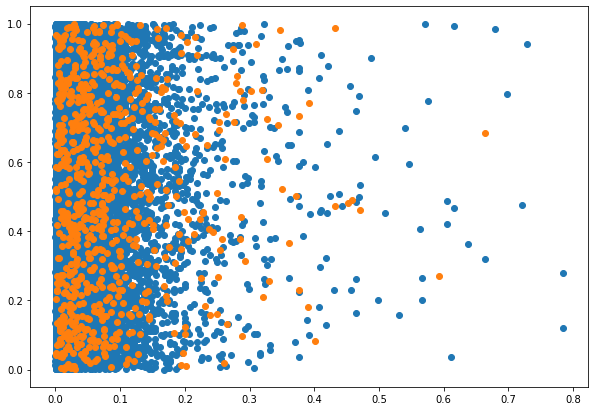

In [18]:
xgb_model = XGBClassifier(eval_metric = scorer).fit(x_train, y_train)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [19]:
y_pred = xgb_model.predict(x_test)
print('Kappa:',cohen_kappa_score(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test,y_pred))

Kappa: 0.0026193911225470545
Accuracy: 0.9583887617730006


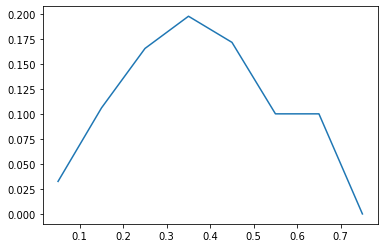

In [21]:
proba_plot(y_test,prediction,0.1)

Score: 0.5040151184057013


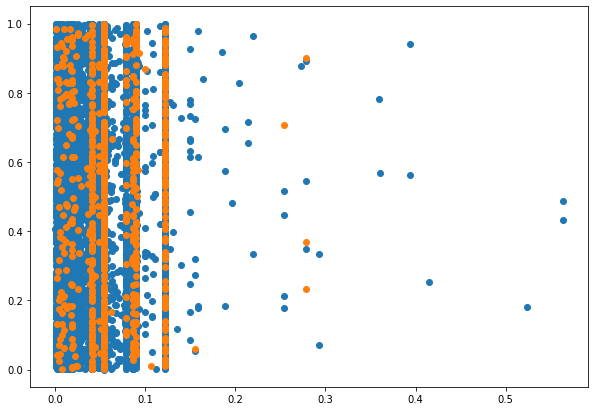

In [106]:
imp = xgb_model.feature_importances_ > 0.1
xgb_model = XGBClassifier(eval_metric = scorer).fit(x_train[:,imp], y_train)
prediction = transform(xgb_model.predict_proba(x_test[:,imp])[:,1],1)
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [25]:
from imblearn.over_sampling import SMOTE

Score: 0.5242447168355693


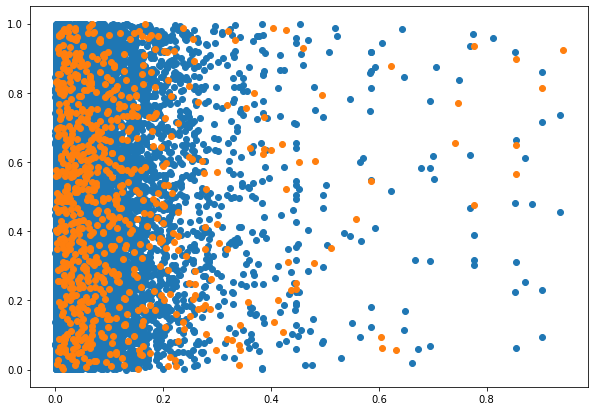

In [107]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBClassifier().fit(x_smote, y_smote)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

In [70]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [73]:
x,y = df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values
cv = KFold(n_splits = 4)
param_grid = {'scale_pos_weight':list(range(1,251,5))}
model = XGBRegressor()
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, scoring = scorer,verbose = 3,cv = cv)
grid_result = grid.fit(x,y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [74]:
grid_result.best_params_

{'scale_pos_weight': 76}

Score: 0.609354732812457


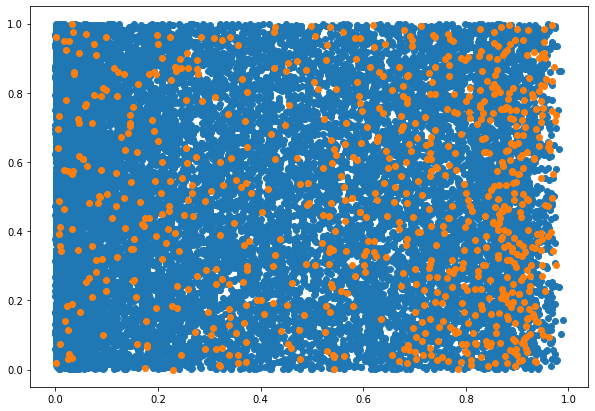

In [30]:
xgb_model = XGBClassifier(scale_pos_weight = 76).fit(x_train, y_train)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

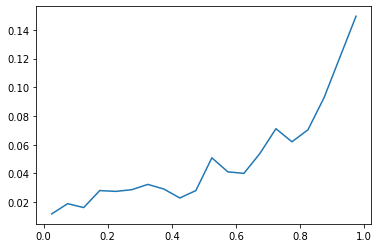

In [31]:
proba_plot(y_test,prediction,0.05)

Score: 0.6153892526122691


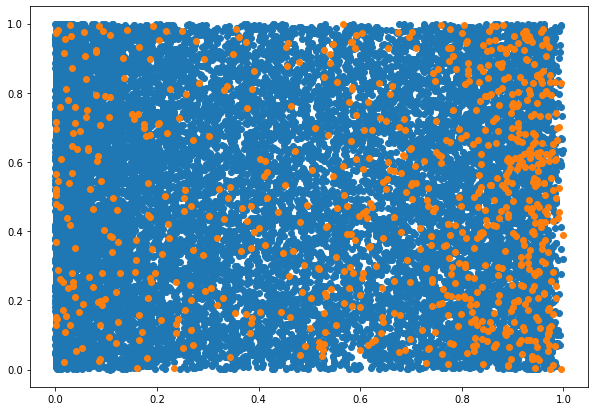

In [26]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBClassifier(scale_pos_weight = 76).fit(x_smote, y_smote)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

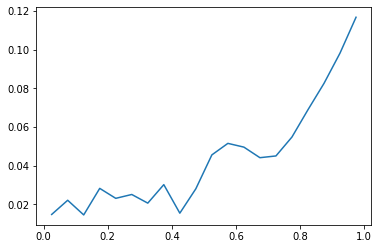

In [29]:
proba_plot(y_test,prediction,0.05)

In [24]:
from sklearn.ensemble import AdaBoostClassifier

Score: 8878.659426269596


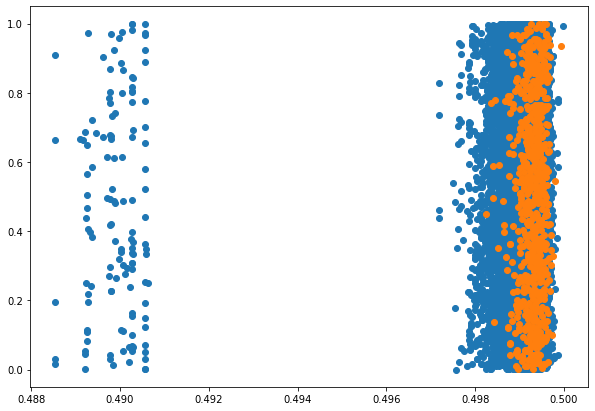

In [92]:
model = AdaBoostClassifier(random_state=0, n_estimators=1000).fit(x_train, y_train)
prediction = model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))